In [1]:
import os
import gdown
import zipfile

# Define the Google Drive file ID and output filename
file_id = "1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ"
output_file = "dataset.zip"

# Download the file using gdown
gdown.download(f"https://drive.google.com/uc?export=download&id={file_id}", output_file, quiet=False)

# Create a directory for extraction
extract_dir = "dataset"
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
try:
    with zipfile.ZipFile(output_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction successful!")
except zipfile.BadZipFile:
    print("Error: The downloaded file is not a valid ZIP file.")

# List extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ
From (redirected): https://drive.google.com/uc?export=download&id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ&confirm=t&uuid=dc8a1d53-afaf-4dd3-8cdb-690631d85f11
To: /content/dataset.zip
100%|██████████| 1.13G/1.13G [00:14<00:00, 78.5MB/s]


Extraction successful!
Extracted files: ['__MACOSX', 'dataset']


In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Visualization

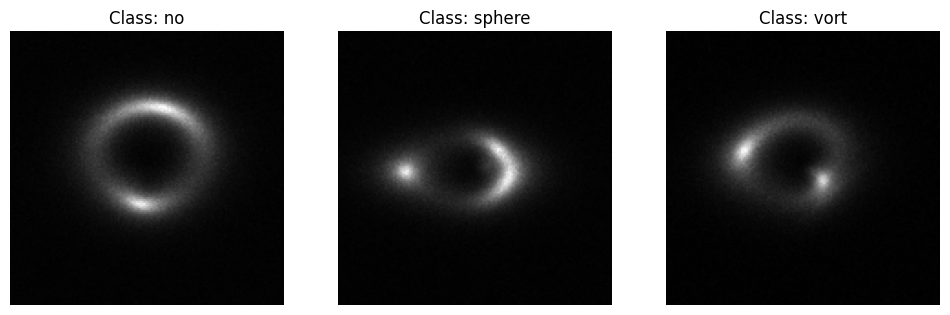

In [4]:

# Define dataset paths
train_dir = "dataset/dataset/train"

# Class names (folders)
class_names = ["no", "sphere", "vort"]

# Function to load a sample image from each class
def load_sample_images(base_dir, class_names):
    sample_images = {}

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        files = os.listdir(class_path)

        # Load the first available .npy file in the class folder
        for file in files:
            if file.endswith(".npy"):
                file_path = os.path.join(class_path, file)
                image = np.load(file_path)

                # Ensure the image is 2D (remove extra dimension)
                if image.shape[0] == 1:  # Shape (1, H, W) -> (H, W)
                    image = image.squeeze(0)

                sample_images[class_name] = image
                break  # Take only one sample per class

    return sample_images

# Load images
sample_images = load_sample_images(train_dir, class_names)

# Function to plot images
def plot_images(images_dict):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for i, (label, image) in enumerate(images_dict.items()):
        ax = axes[i]
        ax.imshow(image, cmap="gray")  # Assuming grayscale images
        ax.set_title(f"Class: {label}")
        ax.axis("off")

    plt.show()

# Display the images
plot_images(sample_images)


In [5]:
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import glob

class GravitationalLensImage(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.classes = ['no', 'sphere', 'vort']
        self.images, self.labels = self._load_images_and_labels()

    def _load_images_and_labels(self):
        images, labels = [], []
        for label, cls in enumerate(self.classes):
            files = glob.glob(os.path.join(self.main_dir, cls, '*.npy'))
            for file_path in files:
                images.append(np.load(file_path))
                labels.append(label)
        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = np.squeeze(image)
            image = np.clip(image * 255.0, 0, 255).astype(np.uint8)
            image = Image.fromarray(image)
            image = self.transform(image)
        return image, label

In [8]:
from torchvision.transforms import InterpolationMode
from torch.utils.data import random_split
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dir_dataset = GravitationalLensImage(main_dir='dataset/dataset/train', transform=transform)
test_dataset = GravitationalLensImage(main_dir='dataset/dataset/val', transform=transform)


num_images = len(train_dir_dataset)
print(num_images)

# number of images for training (90%) and testing (10%)
train_size = int(num_images * 0.9)
val_size = num_images - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dir_dataset, [train_size, val_size])

30000


In [9]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [10]:
for i, data in enumerate(train_loader, 0):
    print(data[0].shape)
    break

torch.Size([128, 1, 150, 150])


## Efficient Net

In [11]:
import torch
from torch import nn
from torchvision.models import efficientnet_b1
from torchvision import models

class EfficientNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(EfficientNet, self).__init__()
        self.in_channel = in_channel
        self.num_classes = num_classes

        self.effnet = efficientnet_b1(weights ='DEFAULT')

        self.effnet.features[0][0] = nn.Conv2d(self.in_channel, 32, kernel_size=3, stride=2, padding=1, bias=False)

        num_ftrs = self.effnet.classifier[1].in_features
        self.effnet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 100),
        )

        self.lin1 = nn.Linear(100, self.num_classes)

    def forward(self, x):
        x = self.effnet(x)
        x = self.lin1(x)
        return x


In [12]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def train_model(model, criterion, optimizer, train_loader, Val_loader, num_epochs, device, scheduler=None):
    model.to(device)
    losses = []  # Store the loss at each epoch

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()  # Ensure model is in "training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Transfer inputs and labels to GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        # Update the learning rate if a scheduler is provided
        if scheduler is not None:
            scheduler.step()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)  # Store the loss

        # Print loss at the end of each epoch
        print(f'Epoch {epoch + 1} completed, Loss: {epoch_loss:.6f}')

        # Validation after every 5 epochs
        if (epoch + 1) % 5 == 0:
            correct = 0
            total = 0
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                for inputs, labels in Val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print(f'Validation Accuracy after epoch {epoch + 1}: {100 * correct / total:.2f}%')

        running_loss = 0.0

    print('Finished Training')

    # Plot the loss vs epoch
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show()

In [13]:
import torch

def test_model(model, test_loader, device):
    # Ensure model is in evaluation mode
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad(): # No need to track gradients
        for images, labels in test_loader:
            # Move images and labels to the designated device (GPU or CPU)
            images, labels = images.to(device), labels.to(device)

            # Forward pass to get outputs
            outputs = model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the test images: {accuracy}%')
    return accuracy


In [14]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

def compute_roc_auc(model, test_loader, device):
    # Define class labels directly within the function
    class_labels = ['no', 'sphere', 'vort']
    num_classes = len(class_labels)

    model.eval()
    model.to(device)

    y_pred = []
    y_true = []

    # Collect all labels and predictions
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            y_pred.append(probabilities)
            y_true.append(labels.cpu().numpy())

    # Convert the lists to a numpy array
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)

    # Binarize the true labels in a one-vs-all fashion
    y_true_binary = label_binarize(y_true, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(class_labels[i], roc_auc[i]))

    # Plot the diagonal line for random chance
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

In [15]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrix(model, test_loader, device, num_classes):
    # Define class labels
    class_labels = ['no', 'sphere', 'vort']

    model.eval()
    model.to(device)

    y_pred = []
    y_true = []

    # Gather the true labels and predictions from the model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # Compute the confusion matrix using sklearn's confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model_efficientnet = EfficientNet(in_channel=1, num_classes=3)
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model_efficientnet)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), 0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 142MB/s]


Epoch 1 completed, Loss: 1.088315
Epoch 2 completed, Loss: 0.865503
Epoch 3 completed, Loss: 0.546336
Epoch 4 completed, Loss: 0.388899
Epoch 5 completed, Loss: 0.308017
Validation Accuracy after epoch 5: 87.97%
Epoch 6 completed, Loss: 0.256634
Epoch 7 completed, Loss: 0.220660
Epoch 8 completed, Loss: 0.193940
Epoch 9 completed, Loss: 0.172760
Epoch 10 completed, Loss: 0.157426
Validation Accuracy after epoch 10: 91.97%
Epoch 11 completed, Loss: 0.139936
Epoch 12 completed, Loss: 0.119084
Epoch 13 completed, Loss: 0.109629
Epoch 14 completed, Loss: 0.106029
Epoch 15 completed, Loss: 0.093632
Validation Accuracy after epoch 15: 92.17%
Epoch 16 completed, Loss: 0.087934
Epoch 17 completed, Loss: 0.073726
Epoch 18 completed, Loss: 0.074914
Epoch 19 completed, Loss: 0.066717
Epoch 20 completed, Loss: 0.064998
Validation Accuracy after epoch 20: 92.93%
Epoch 21 completed, Loss: 0.059466
Epoch 22 completed, Loss: 0.054168
Epoch 23 completed, Loss: 0.050606
Epoch 24 completed, Loss: 0.05163

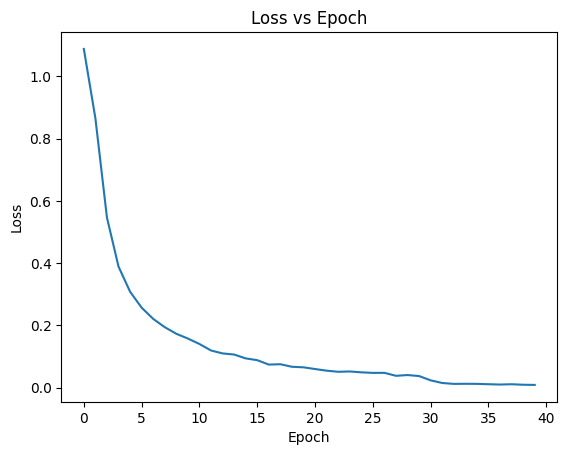

In [17]:
train_model(model=model_efficientnet, criterion=criterion, optimizer=optimizer, train_loader=train_loader, Val_loader=val_loader, num_epochs=40, device=device, scheduler=scheduler)

In [18]:
torch.save(model_efficientnet.state_dict(), 'model_efficientnet.pth')

In [19]:
model_efficientnet.load_state_dict(torch.load('model_efficientnet.pth', map_location=device))

<All keys matched successfully>

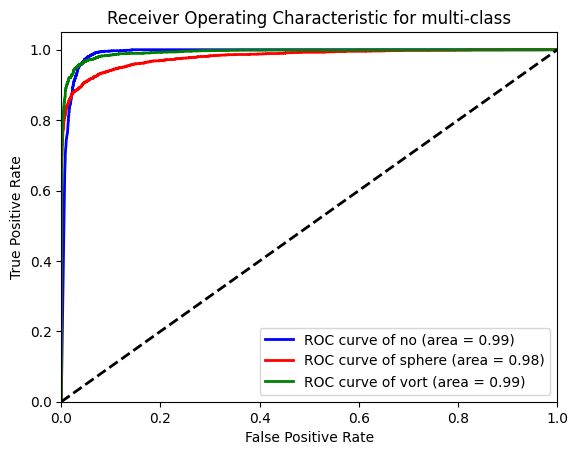

Area Under curve for different classes is :{0: 0.9900747200000001, 1: 0.9791867199999998, 2: 0.9926926}


In [20]:
roc_effnet = compute_roc_auc(model_efficientnet, test_loader, device)
print(f'Area Under curve for different classes is :{roc_effnet}')

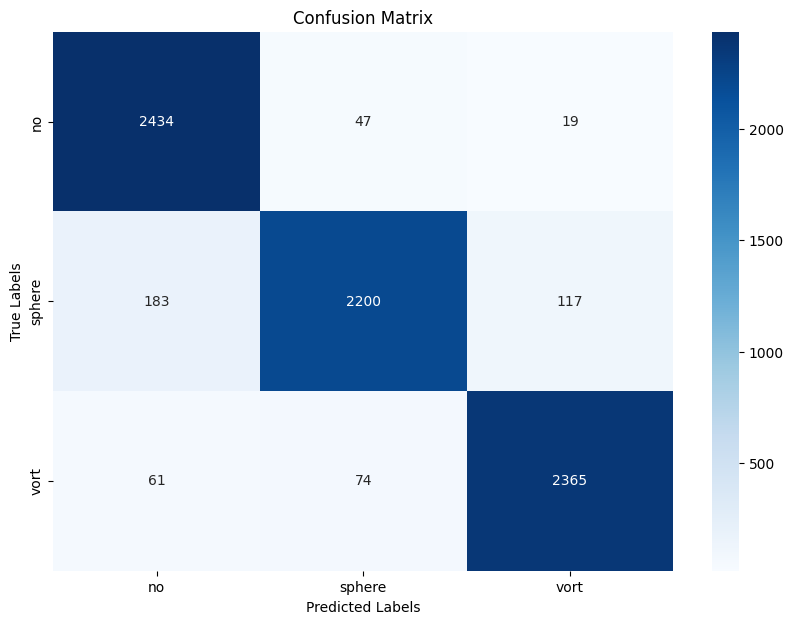

In [21]:
compute_confusion_matrix(model_efficientnet, test_loader, device, 3)

In [22]:
test_Acc = test_model(model_efficientnet, test_loader, device)

Accuracy of the network on the test images: 93.32%


## Dense Net

In [23]:
from torchvision.models import densenet121

class DenseNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = densenet121(weights='DEFAULT')
        self.densenet.features[0] = nn.Conv2d(in_channel, 64, kernel_size=7, stride=2, padding=3, bias=False)

        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x


In [24]:
model_dense = DenseNet(1, 3)
if torch.cuda.device_count() > 1:
    model_dense = torch.nn.DataParallel(model_dense)
criterion_dense = nn.CrossEntropyLoss()
optimizer_dense = optim.Adam(model_dense.parameters(), 0.0001)
scheduler_dense = StepLR(optimizer_dense, step_size=30, gamma=0.1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 155MB/s]


Epoch 1 completed, Loss: 1.103133
Epoch 2 completed, Loss: 0.986138
Epoch 3 completed, Loss: 0.814868
Epoch 4 completed, Loss: 0.647968
Epoch 5 completed, Loss: 0.503258
Validation Accuracy after epoch 5: 61.77%
Epoch 6 completed, Loss: 0.379146
Epoch 7 completed, Loss: 0.292545
Epoch 8 completed, Loss: 0.218780
Epoch 9 completed, Loss: 0.162424
Epoch 10 completed, Loss: 0.121074
Validation Accuracy after epoch 10: 70.53%
Epoch 11 completed, Loss: 0.093268
Epoch 12 completed, Loss: 0.077865
Epoch 13 completed, Loss: 0.061646
Epoch 14 completed, Loss: 0.062289
Epoch 15 completed, Loss: 0.050294
Validation Accuracy after epoch 15: 82.60%
Epoch 16 completed, Loss: 0.042628
Epoch 17 completed, Loss: 0.041261
Epoch 18 completed, Loss: 0.031101
Epoch 19 completed, Loss: 0.046031
Epoch 20 completed, Loss: 0.032498
Validation Accuracy after epoch 20: 80.93%
Finished Training


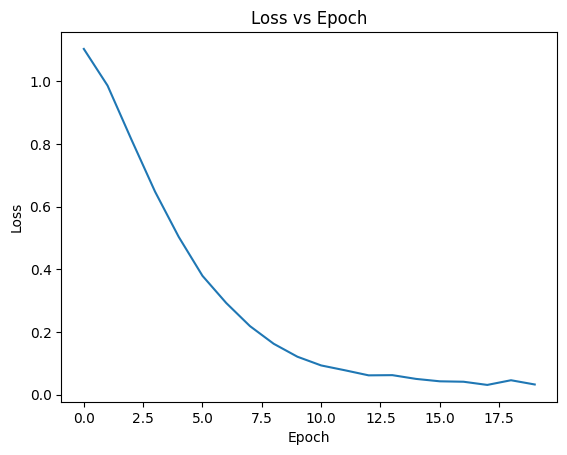

In [25]:
train_model(model=model_dense, criterion=criterion_dense, optimizer=optimizer_dense, train_loader=train_loader, Val_loader=val_loader, num_epochs=20, device=device, scheduler=scheduler_dense)

In [26]:
torch.save(model_dense.state_dict(), 'model_densenet.pth')

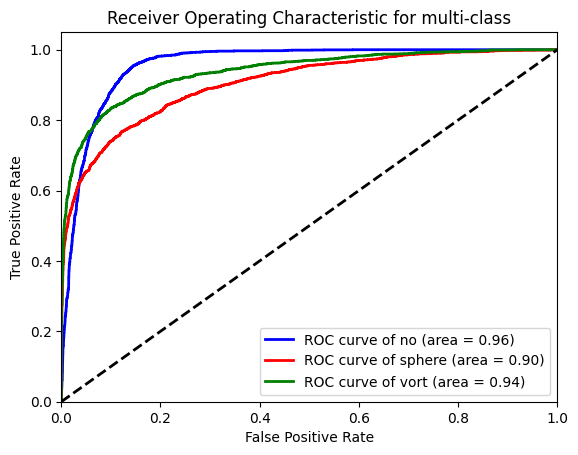

Area Under curve for different classes is :{0: 0.9564866000000001, 1: 0.90410688, 2: 0.9364613199999999}


In [27]:
roc_dense = compute_roc_auc(model_dense, test_loader, device)
print(f'Area Under curve for different classes is :{roc_dense}')

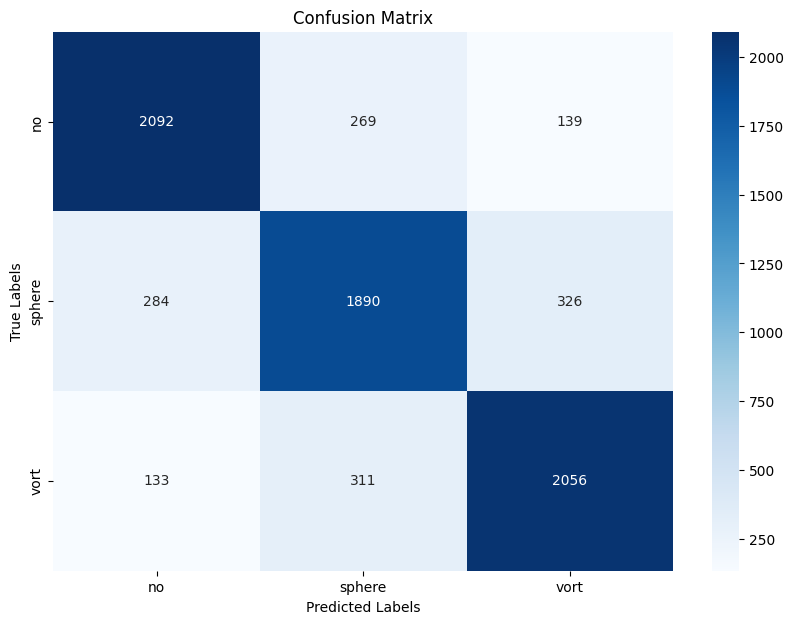

In [28]:
compute_confusion_matrix(model_dense, test_loader, device, 3)

In [29]:
test_Acc = test_model(model_dense, test_loader, device)

Accuracy of the network on the test images: 80.50666666666666%


## AlexNet

In [30]:
from torchvision.models import alexnet

class AlexNet(nn.Module):
    def __init__(self, in_channel, num_classes):
        super(AlexNet, self).__init__()
        self.alexnet = alexnet(weights='DEFAULT')
        self.alexnet.features[0] = nn.Conv2d(in_channel, 64, kernel_size=11, stride=4, padding=2)

        num_ftrs = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return x

In [31]:
model_alex = AlexNet(1, 3)
if torch.cuda.device_count() > 1:
    model_alex = torch.nn.DataParallel(model_alex)
criterion_alex = nn.CrossEntropyLoss()
optimizer_alex = optim.Adam(model_alex.parameters(), 0.0001)
scheduler_alex = StepLR(optimizer_alex, step_size=30, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 154MB/s]


Epoch 1 completed, Loss: 1.100462
Epoch 2 completed, Loss: 1.099151
Epoch 3 completed, Loss: 1.098941
Epoch 4 completed, Loss: 1.099567
Epoch 5 completed, Loss: 1.099132
Validation Accuracy after epoch 5: 33.97%
Epoch 6 completed, Loss: 1.098737
Epoch 7 completed, Loss: 1.098695
Epoch 8 completed, Loss: 1.098700
Epoch 9 completed, Loss: 1.098685
Epoch 10 completed, Loss: 1.098752
Validation Accuracy after epoch 10: 34.40%
Epoch 11 completed, Loss: 1.098956
Epoch 12 completed, Loss: 1.098693
Epoch 13 completed, Loss: 1.098783
Epoch 14 completed, Loss: 1.098742
Epoch 15 completed, Loss: 1.098697
Validation Accuracy after epoch 15: 32.97%
Epoch 16 completed, Loss: 1.098730
Epoch 17 completed, Loss: 1.098691
Epoch 18 completed, Loss: 1.098667
Epoch 19 completed, Loss: 1.098690
Epoch 20 completed, Loss: 1.098686
Validation Accuracy after epoch 20: 32.97%
Finished Training


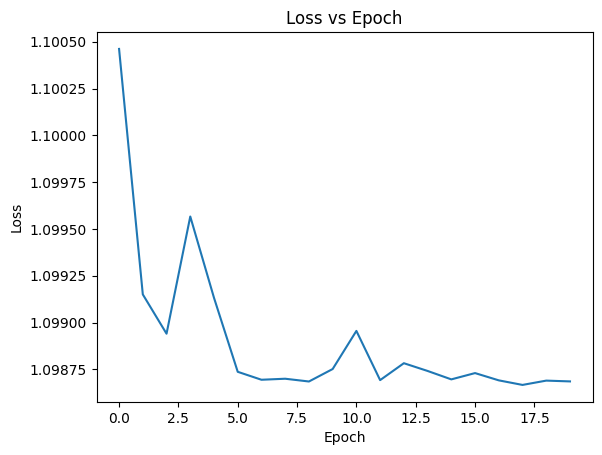

In [32]:
train_model(model=model_alex, criterion=criterion_alex, optimizer=optimizer_alex, train_loader=train_loader, Val_loader=val_loader, num_epochs=20, device=device, scheduler=scheduler)

In [33]:
torch.save(model_alex.state_dict(), 'model_alexnet.pth')

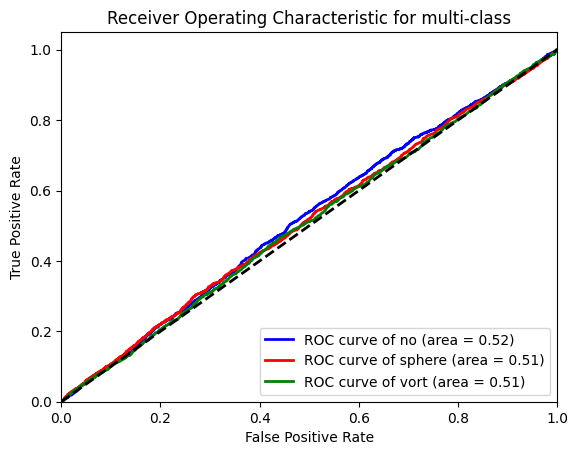

Area Under curve for different classes is :{0: 0.52073956, 1: 0.51414204, 2: 0.50734384}


In [34]:
roc_alex = compute_roc_auc(model_alex, test_loader, device)
print(f'Area Under curve for different classes is :{roc_alex}')